In [1]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import yaml

from matplotlib import pyplot as plt
import matplotlib.patches as mpl_patches
%matplotlib inline

from scipy.stats import linregress
from sklearn.metrics import mean_squared_error

In [2]:
plot_columns = np.arange(-990,990,15)
str_plot_columns = [str(m) for m in plot_columns]

In [3]:
len_string = '100-200bp'
samples_yaml = '../../CRPC/TFBS_'+len_string+'_nucleosome_profiling/config/samples.GC.yaml'
single_fragment_length_dir ='../../Griffin_single_fragment_length/CRPC_deep/CRPC_'+len_string+'_single_fragment_length_np/results/'
multi_fragment_length_dir ='../../CRPC/TFBS_'+len_string+'_nucleosome_profiling/results/'
tfx_path = '../../metadata/CRPC/deepWGS_tumor_fraction.txt'

stat_single_fragment_path = 'files/single_fragment_length_'+len_string+'.tsv'
stat_multi_fragment_path = 'files/multi_fragment_length_'+len_string+'.tsv'


In [4]:
with open(samples_yaml, 'r') as f:
    samples = yaml.safe_load(f)
    
samples = list(samples['samples'].keys())


In [5]:
#import data
single_fragment_data = pd.DataFrame()
multi_fragment_data = pd.DataFrame()

for sample in samples:
    file1 = single_fragment_length_dir+sample+'/'+sample+'.GC_corrected.coverage.tsv'
    data1 = pd.read_csv(file1, sep='\t')
    single_fragment_data = single_fragment_data.append(data1)
    
    file2 = multi_fragment_length_dir+sample+'/'+sample+'.GC_corrected.coverage.tsv'
    data2 = pd.read_csv(file2, sep='\t')
    multi_fragment_data = multi_fragment_data.append(data2)

#merge with tumor fraction
tfx_data = pd.read_csv(tfx_path, sep='\t').rename(columns = {'ID':'sample'})
single_fragment_data = single_fragment_data.merge(tfx_data, on = 'sample')

multi_fragment_data = multi_fragment_data.merge(tfx_data, on = 'sample')

#remove number of sites from site name
single_fragment_data['site_name'] = single_fragment_data['site_name'].str.rsplit('.10000',1,expand=True)[0]
multi_fragment_data['site_name'] = multi_fragment_data['site_name'].str.rsplit('.10000',1,expand=True)[0]

#get site list
sites = single_fragment_data['site_name'].unique()

In [6]:
print(len(single_fragment_data))
print(len(multi_fragment_data))
print(len(multi_fragment_data['site_name'].unique())*len(multi_fragment_data['sample'].unique()))

print(len(multi_fragment_data['site_name'].unique()))
print(len(multi_fragment_data['sample'].unique()))

6786
6786
6786
377
18


In [7]:
#import stat data
stat_single_fragment_data = pd.read_csv(stat_single_fragment_path, sep='\t').set_index('site_name')
stat_multi_fragment_data = pd.read_csv(stat_multi_fragment_path, sep='\t').set_index('site_name')

#create data dict
data = {'single_fragment':
        {'data':single_fragment_data,'stat_data':stat_single_fragment_data},
        'multi_fragment':
        {'data':multi_fragment_data,'stat_data':stat_multi_fragment_data}}

In [8]:
HD_color = 'tab:green'
MBC_color = 'tab:orange'
CRPC_color = 'tab:blue'

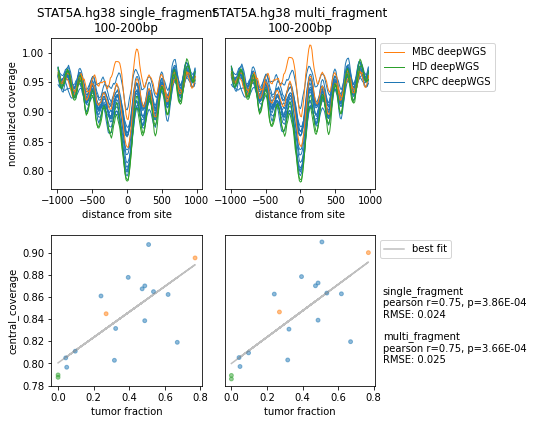

In [9]:
for site_name in ['STAT5A.hg38']:
    ##single figure
    fig,axes = plt.subplots(2,2, figsize=(9,6), sharex = 'row', sharey='row')
    feature = 'central_coverage'
    marker_size = 15

    labels = []
    #plot median +/- IQR
    for i,key in enumerate(data):
        df = data[key]['data']
        stat_data = data[key]['stat_data']
        ax = axes[0,i]
        current = df[(df['site_name']==site_name)].copy()
        #del(df)
        #add color
        current['color'] = np.where(current['sample'].str.contains('HD'),HD_color,current['sample'])
        current['color'] = np.where(current['color'].str.contains('CRPC'),CRPC_color,current['color'])
        current['color'] = np.where(current['color'].str.contains('MBC'),MBC_color,current['color'])

        #plot deepWGS coverage
        for sample in samples:
            current2 = current[current['sample']==sample]
            ax.plot(plot_columns,current2[str_plot_columns].T, color = current2['color'].values[0], linewidth = 1)

        ax.plot(0,1, color = MBC_color, label = 'MBC deepWGS', linewidth = 1)
        ax.plot(0,1, color = HD_color, label = 'HD deepWGS', linewidth = 1)
        ax.plot(0,1, color = CRPC_color, label = 'CRPC deepWGS', linewidth = 1)

        #add legend and labels
        ax.set_title(site_name+' '+key+'\n'+len_string)
        ax.set_xlabel('distance from site')

        #plot ULP scatter
        ax = axes[1,i]
        ax.scatter(current['tumor_fraction'],current[feature], color = current['color'], alpha = 0.5, s = marker_size)

        #plot line of best fit
        lin_reg_slope, lin_reg_intercept, pearson_r, pearson_pval, lin_reg_std_err = linregress(current['tumor_fraction'],current[feature])
        fit_line = lin_reg_slope*current['tumor_fraction']+lin_reg_intercept
        RMSE = np.sqrt(mean_squared_error(current[feature],fit_line))
        
        ax.plot(current['tumor_fraction'],fit_line, color= 'grey', alpha = 0.5, label = 'best fit')
        #ax.legend(loc = 'upper left', bbox_to_anchor = [0,-.2])
        
        #check work
        if not np.isclose(stat_data.loc[site_name+'.10000']['pearson_r_'+feature],pearson_r):
            print('problem!!!!!')
        if not np.isclose(stat_data.loc[site_name+'.10000']['lin_reg_RMSE_'+feature],RMSE):
            print('RMSE problem!!')
    
        ax.set_xlabel('tumor fraction')

        #print(key)
        #print("pearson r:",np.round(pearson_r,2))
        #print("pearson pval:",'{:.1E}'.format(pearson_pval))

        #ylim = ax.get_ylim()
        #ylim_range = ylim[1]-ylim[0]
        #ylim = (ylim[0]-ylim_range*0.02,ylim[1]+ylim_range*0.08)
        #ax.set_ylim(ylim)

        #add the stat text
        handles = [mpl_patches.Rectangle((0, 0), 1, 1, fc="white", ec="white", 
                                 lw=0, alpha=0)]
        label = key+'\npearson r='+str(np.round(pearson_r,2))+', p='+'{:.2E}'.format(pearson_pval)+'\nRMSE: '+'{:.3f}'.format(RMSE)
        labels.append(label)


    for ax in [axes[0,0],axes[0,1],axes[1,0],axes[1,1]]:
        ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')

    axes[1,0].set_ylabel(feature)
    axes[0,0].set_ylabel('normalized coverage')

    axes[0,1].legend(loc = 'upper left', bbox_to_anchor = [1,1]) 
    axes[0,1].text(1.05,.45,labels[0],transform=ax.transAxes)
    axes[0,1].text(1.05,.15,labels[1],transform=ax.transAxes)

    axes[0,1].tick_params(left = False)   

    axes[1,1].legend(loc = 'upper left', bbox_to_anchor = [1,1])


    axes[1,1].tick_params(left = False)   

    fig.tight_layout()
    fig.subplots_adjust(wspace = 0.15, hspace = .3, right = .6, left = .1)
    plt.savefig('plots/'+site_name+'.'+len_string+'.pdf')
    #plt.close()
    

In [10]:
print('done')

done
